# Homework 3 

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

Classification: Forest
Classification: Desert


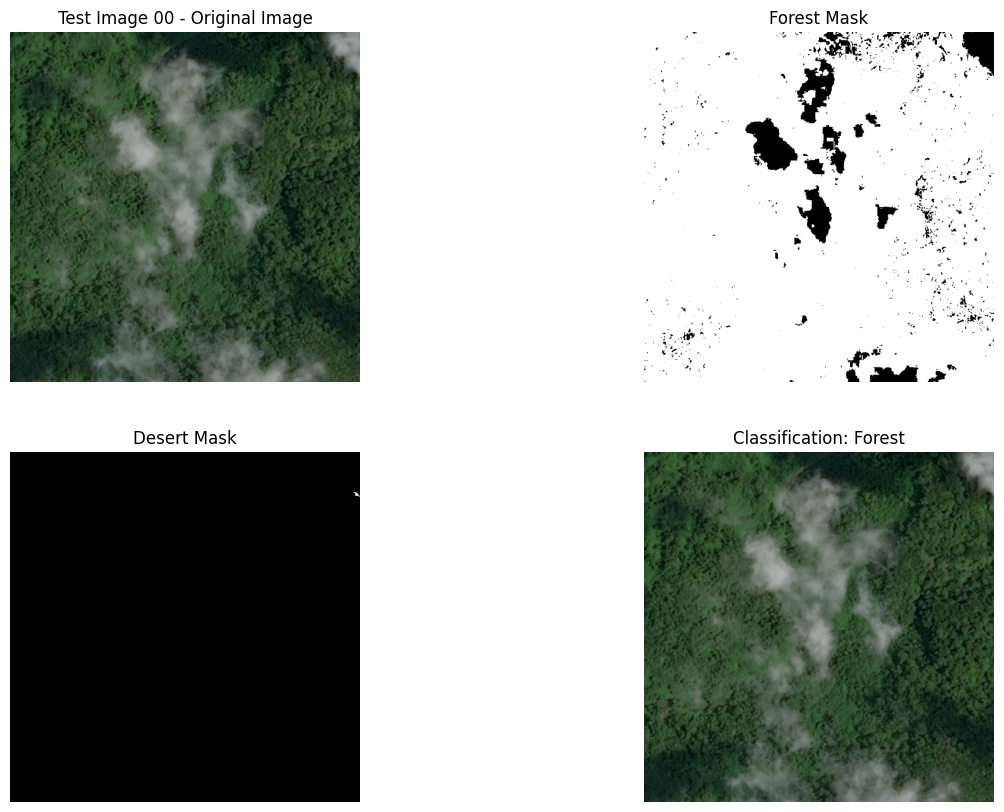

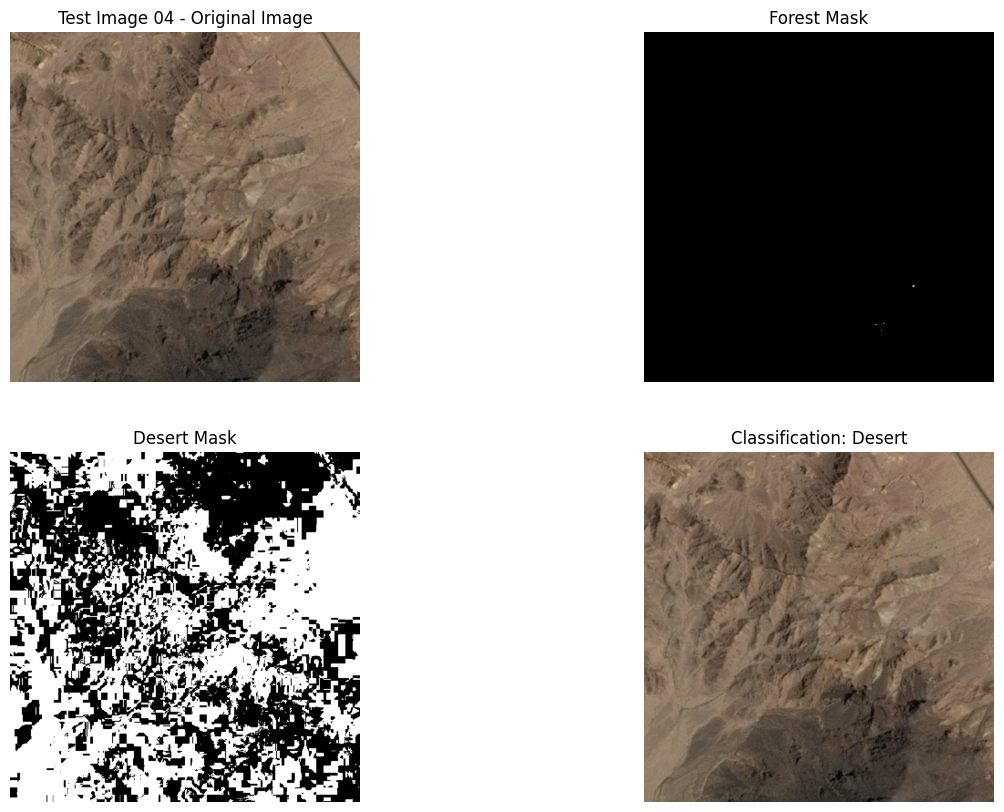

In [6]:
# Ваш код
import cv2
import numpy as np
import matplotlib.pyplot as plt

def classify_image(image_path):
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # задаем диапазоны для леса и пустыни
    forest_lower = np.array([35, 25, 25])
    forest_upper = np.array([85, 255, 255])
    desert_lower = np.array([15, 25, 25])
    desert_upper = np.array([35, 255, 255])

    # создаем маски
    forest_mask = cv2.inRange(hsv_image, forest_lower, forest_upper)
    desert_mask = cv2.inRange(hsv_image, desert_lower, desert_upper)

    # подсчет пикселей
    forest_count = cv2.countNonZero(forest_mask)
    desert_count = cv2.countNonZero(desert_mask)

    # классификация
    if forest_count > desert_count:
        classification = "Forest"
    else:
        classification = "Desert"

    return classification, image, forest_mask, desert_mask

# тестовые изображения
image_path_forest = 'desert_forest/test_image_00.jpg'
classification_forest, image_forest, forest_mask_forest, desert_mask_forest = classify_image(image_path_forest)
print(f"Classification: {classification_forest}")

image_path_desert = 'desert_forest/test_image_04.jpg'
classification_desert, image_desert, forest_mask_desert, desert_mask_desert = classify_image(image_path_desert)
print(f"Classification: {classification_desert}")

# вывод изображений
def show_images(image, forest_mask, desert_mask, classification, title):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'{title} - Original Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(forest_mask, cmap='gray')
    plt.title('Forest Mask')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(desert_mask, cmap='gray')
    plt.title('Desert Mask')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f'Classification: {classification}')
    plt.axis('off')

    plt.show()

show_images(image_forest, forest_mask_forest, desert_mask_forest, classification_forest, 'Test Image 00')
show_images(image_desert, forest_mask_desert, desert_mask_desert, classification_desert, 'Test Image 04')


# Задача №2 - Реализовать Image-blending на основе сшивки по градиентам

Задача - взять фото двух лиц : ваше и друга, с помощью метода Poisson image editing совместить глаза, нос и рот с первого изображения со вторым. Суть в том, что при использовании такого метода границы совмещенного изображения не видны.

Статья, где описан метод  

Patrick Pérez, Michel Gangnet, and Andrew Blake. 2003. Poisson image editing. ACM Trans. Graph. 22, 3 (July 2003), 313–318. https://doi.org/10.1145/882262.882269

Пример такого совмещения:

<img src="../homework/blending/blending.png" alt="Drawing" style="width: 700px;"/>


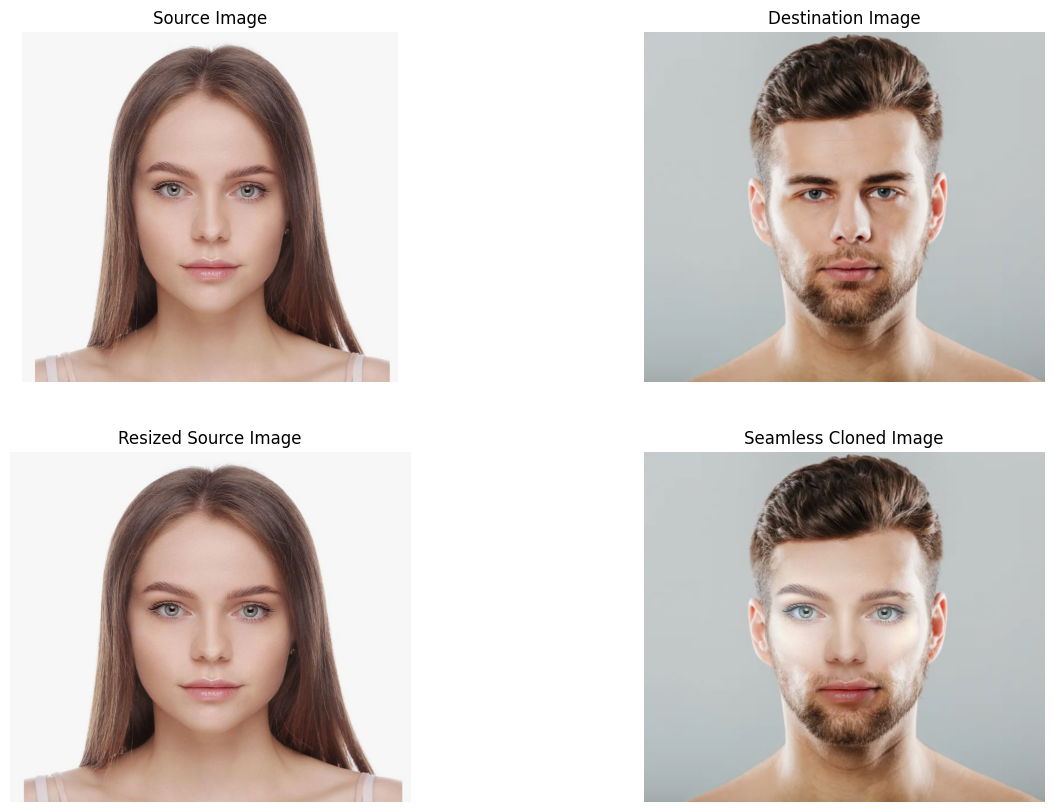

True

In [5]:
# Ваш код
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка предобученных каскадов Хаара
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
nose_cascade = cv2.CascadeClassifier('haar/haarcascade_mcs_nose.xml')  
mouth_cascade = cv2.CascadeClassifier('haar/haarcascade_mcs_mouth.xml')  

# Проверка загрузки каскадов
if face_cascade.empty() or eye_cascade.empty() or nose_cascade.empty() or mouth_cascade.empty():
    raise ValueError("Не удалось загрузить один из каскадов Хаара. Проверьте пути к файлам каскадов.")

def detect_face_parts(img_path):
    # Загрузка изображения
    img = cv2.imread(img_path)

    # Проверка загрузки изображения
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение по пути {img_path}")

    # Преобразование изображения в серый цвет
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Обнаружение лиц
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Создание маски на основе обнаруженных частей лица
    mask = np.zeros_like(gray)
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        # Обнаружение глаз
        eyes = eye_cascade.detectMultiScale(roi_gray)
        for (ex, ey, ew, eh) in eyes:
            cv2.ellipse(mask, ((ex + ew//2 + x), (ey + eh//2 + y)), (ew//2, eh//2), 0, 0, 360, 255, -1)

        # Обнаружение носа
        nose = nose_cascade.detectMultiScale(roi_gray)
        for (nx, ny, nw, nh) in nose:
            cv2.ellipse(mask, ((nx + nw//2 + x), (ny + nh//2 + y)), (nw//2, nh//2), 0, 0, 360, 255, -1)
        
        # Обнаружение рта
        mouth = mouth_cascade.detectMultiScale(roi_gray)
        for (mx, my, mw, mh) in mouth:
            cv2.ellipse(mask, ((mx + mw//2 + x), (my + mh//2 + y)), (mw//2, mh//2), 0, 0, 360, 255, -1)

    return img, mask

# Загрузка изображений
src_img, src_mask = detect_face_parts("faces/face_1.jpg")
dst_img, dst_mask = detect_face_parts("faces/face_2.jpg")

# Приведение изображений к одному размеру
height = dst_img.shape[0]
width = dst_img.shape[1]
src_resized = cv2.resize(src_img, (width, height))
src_mask_resized = cv2.resize(src_mask, (width, height))

# Центр для применения метода seamless cloning
center = (width // 2, height // 2)

# Применение метода seamless cloning
seamless_img = cv2.seamlessClone(src_resized, dst_img, src_mask_resized, center, cv2.NORMAL_CLONE)

# Вывод изображений с использованием matplotlib
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB))
plt.title('Source Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB))
plt.title('Destination Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(src_resized, cv2.COLOR_BGR2RGB))
plt.title('Resized Source Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(seamless_img, cv2.COLOR_BGR2RGB))
plt.title('Seamless Cloned Image')
plt.axis('off')

plt.show()

# Сохранение результата
cv2.imwrite('seamless_cloned_image.jpg', seamless_img)


# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

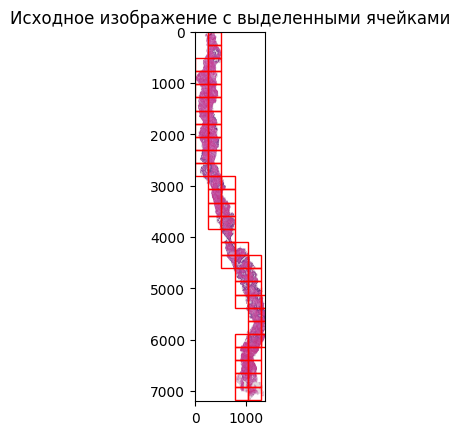

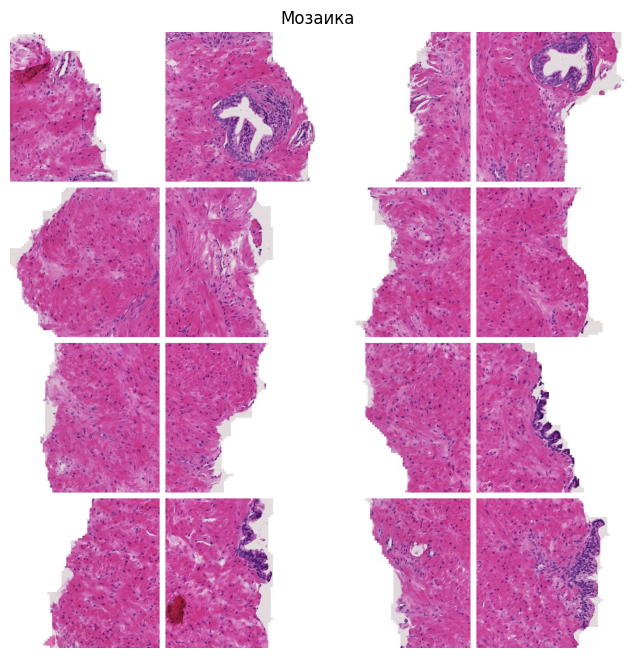

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import matplotlib.patches as patches

def extract_and_display_cells(image_path, cell_size, cell_count, padding=10):
    image = Image.open(image_path)
    image_np = np.array(image)
    
    # размеры изображения
    img_height, img_width, _ = image_np.shape
    
    cells = []
    extracted_cells = 0
    fig, ax = plt.subplots(1)

    ax.imshow(image_np)
    
    # проход по изображению с шагом размера ячейки
    for y in range(0, img_height, cell_size):
        for x in range(0, img_width, cell_size):
            if extracted_cells >= cell_count:
                break
            
            # вырезаем ячейку
            cell = image_np[y:y + cell_size, x:x + cell_size]
            
            # проверяем, содержит ли ячейка "полезную" информацию
            if cell.mean() < 240:  # порог для фильтрации пустых участков
                cells.append(cell)
                extracted_cells += 1
                
                # добавляем рамку на исходное изображение для визуализации
                rect = patches.Rectangle((x, y), cell_size, cell_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

    plt.title("Исходное изображение с выделенными ячейками")
    plt.show()

    if len(cells) > 16:
        cells = cells[:16]
    elif len(cells) < 16:
        cells = cells * (16 // len(cells)) + cells[:16 % len(cells)]
    
    # размер сетки и подготовка мозаики с учетом padding
    grid_size = 4
    mosaic_size = grid_size * cell_size + (grid_size - 1) * padding
    mosaic = np.ones((mosaic_size, mosaic_size, 3), dtype=np.uint8) * 255  # фон белого цвета

    for idx, cell in enumerate(cells):
        i = idx // grid_size
        j = idx % grid_size
        y_start = i * (cell_size + padding)
        x_start = j * (cell_size + padding)
        mosaic[y_start:y_start + cell_size, x_start:x_start + cell_size] = cell

    plt.figure(figsize=(8, 8))
    plt.imshow(mosaic)
    plt.axis('off')
    plt.title("Мозаика")
    plt.show()

extract_and_display_cells("cells/train1_1.jpeg", cell_size=256, cell_count=56)



### Дополнительный вопрос
Чтобы подобрать подходящие значения аргументов для большинства изображений, можно:
1. **Анализировать размеры** изображений, чтобы выбрать подходящий размер ячейки, например, 256x256 или 512x512 пикселей.
2. **Оценить среднее количество ячеек** с клетками для каждой картинки и установить это значение для `cell_count`.
3. **Настроить порог фильтрации пустых областей** через эксперименты или кластеризацию пикселей.
4. **Протестировать на небольшом подмножество изображений**, подбирая значения параметров вручную.
5. **Использовать обратную связь** от модели классификации, чтобы уточнить параметры. 
